# Seminar: Dimensionality reduction

#### Seminar structure:

* SVD (Cingular Value Decomposition) and PCA (Principal Component Analysis) from scratch
* Singular Value Decomposition of an Image.
* The ` Olivetti Faces dataset` component analysis.
* Instrinsic dimensionality estimation.
* Manifold learning.
* ----> Autoencoding.

#### Seminar interactive board: https://www.menti.com/b9jckhyeq5

__Autoencoders__ or how it was on the lectures - replicational neural networks - are unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

It is good for:
* redusing noise in the data
* building stable networks for data invariands
* data compression

The encoder brings the data from a high dimensional input to a __Latent space__ or *bottleneck* layer, where the number of neurons is the smallest. Then, the decoder takes this encoded input and converts it back to the original input shape — in our case an image. The latent space is the space in which the data lies in the bottleneck layer.

![lol](https://www.compthree.com/images/blog/ae/ae.png)

In [1]:
# imports
from IPython.display import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.utils.data as torch_data

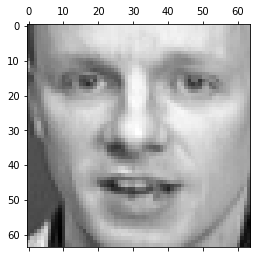

In [2]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split


data = fetch_olivetti_faces(shuffle=True, random_state= 42 ).data
target = fetch_olivetti_faces(shuffle=True, random_state= 42).target

X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, test_size=0.33, random_state=42)


#data
plt.matshow(data[0].reshape(64,64), cmap='gray');

#### 1. Write `torch` compatible dataset and dataloader

In [3]:
class FacesData(torch_data.Dataset):
    def __init__(self, X, y):
        super(FacesData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)                                                           
        self.y = y.astype(int)
    
    def __len__(self):
        return self.X.shape[0] ### YOUR CODE HERE ###
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx] ### YOUR CODE HERE ###

In [4]:
train_dset = FacesData(X_train, y_train) ### YOUR CODE HERE ###
test_dset = FacesData(X_test, y_test) ### YOUR CODE HERE ###

print(train_dset[5])

(tensor([[0.4504, 0.6694, 0.7893,  ..., 0.1240, 0.1240, 0.1240]]), 18)


#### 2. Write Autoencoder model as object of  `torch.nn.Module` class

It takes as input encoder and decoder (it will be small neural networks).

In [9]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        z = self.encoder(x)  ### YOUR CODE HERE ###
        x_out = self.decoder(z)  ### YOUR CODE HERE ###
        return x_out #

#### 3. Define Encoder and Decoder, whey will be symmetrical

You should define variable for bottelneck layer - `hid` and for number of neurons in the whole network  - `ss`.

In [14]:
128*4

512

In [10]:
ss = 128

samples, sample_size = data.shape

encoder = lambda hid: nn.Sequential(
                        nn.Linear(sample_size, ss*4),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*4, ss*2),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*2, hid)
                        )  ### YOUR CODE HERE ###

decoder =  lambda hid: nn.Sequential(
                        nn.Linear(hid, ss*2),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*2, ss*4),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss*4, sample_size),
                        nn.Sigmoid(),
                        )  ### YOUR CODE HERE ###

#### 4. Defining criterion, optimizer, scheduler and data loaders

Choose criterion, it will be `nnMSEloss` for now, optimizer and scheduler for optimiser

Quiestion: why do we need the scheduler?

In [11]:
#device = 'cuda:0'  ### YOUR CODE HERE ###
device = 'cpu'

net = MyFirstAE(encoder(50), decoder(50))  ### YOUR CODE HERE ###
criterion = nn.MSELoss() ### YOUR CODE HERE ###
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)  ### YOUR CODE HERE ###
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)  ### YOUR CODE HERE ###


train_loader = torch_data.DataLoader(train_dset, batch_size=100, shuffle=True)  ### YOUR CODE HERE ###
val_loader = torch_data.DataLoader(test_dset, batch_size=100, shuffle=False)  ### YOUR CODE HERE ###

#### 5. The main part - write `train` for the network

Train will take the batch, send to the devise, encode and decode it and calculate the loss.

In [6]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, _ in train_loader:
             ### YOUR CODE HERE ###
            X = X.to(device)
            
            out = net(X)
            loss = criterion(out, X)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
             ###

        net.eval()
        for X, _ in val_loader:
             ### YOUR CODE HERE ###
            X = X.to(device)
            out = net(X)
            val_loss = criterion(out, X)
             ###
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))
            
    if save_dir is not None:
        torch.save(model.state_dict(), os.path.join(save_dir, 'model.pth'))

#### 5. Enjoy the training

In [12]:
# for `MSE` loss lets get < 0.011 on validation, with AE "bottleneck" = 50

train(300, net, criterion, optimizer, train_loader, val_loader, scheduler)  ### YOUR CODE HERE ###

Epoch 15/300 || Loss:  Train 0.0195 | Validation 0.0188
Epoch 30/300 || Loss:  Train 0.0179 | Validation 0.0178
Epoch 45/300 || Loss:  Train 0.0188 | Validation 0.0173
Epoch 60/300 || Loss:  Train 0.0172 | Validation 0.0170
Epoch 75/300 || Loss:  Train 0.0164 | Validation 0.0150
Epoch 90/300 || Loss:  Train 0.0146 | Validation 0.0141
Epoch 105/300 || Loss:  Train 0.0139 | Validation 0.0137
Epoch 120/300 || Loss:  Train 0.0135 | Validation 0.0134
Epoch 135/300 || Loss:  Train 0.0132 | Validation 0.0128
Epoch 150/300 || Loss:  Train 0.0122 | Validation 0.0124
Epoch 165/300 || Loss:  Train 0.0119 | Validation 0.0121
Epoch 180/300 || Loss:  Train 0.0123 | Validation 0.0119
Epoch 195/300 || Loss:  Train 0.0113 | Validation 0.0118
Epoch 210/300 || Loss:  Train 0.0112 | Validation 0.0118
Epoch 225/300 || Loss:  Train 0.0112 | Validation 0.0117
Epoch 240/300 || Loss:  Train 0.0123 | Validation 0.0117
Epoch 255/300 || Loss:  Train 0.0107 | Validation 0.0116
Epoch 270/300 || Loss:  Train 0.0118 

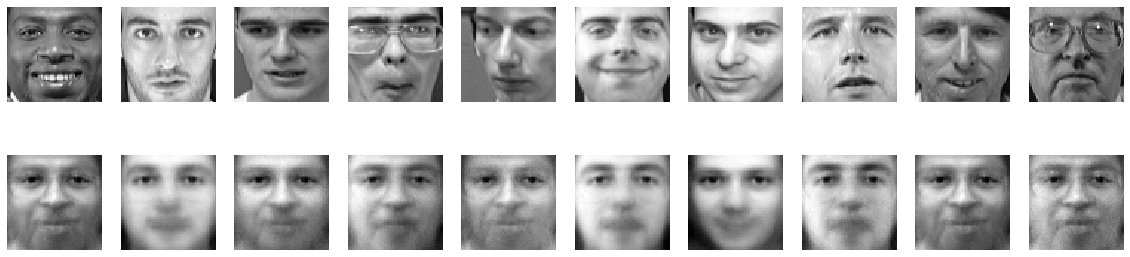

In [75]:
 ### it was for AE with ss = 128, epochs = 500, bottleneck = 50, MSE = 0.011 val
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

n_pics = 64

for i in range(10):
    im = train_dset[i][0]
    rec = net(im.reshape(1,n_pics**2).to(device))[0]
    ax[0, i].imshow(im[0].reshape(n_pics,n_pics), cmap = "gray");
    ax[1, i].imshow(rec.detach().cpu().reshape(n_pics,n_pics), cmap = "gray");
    ax[0, i].axis('off')
    ax[1, i].axis('off')

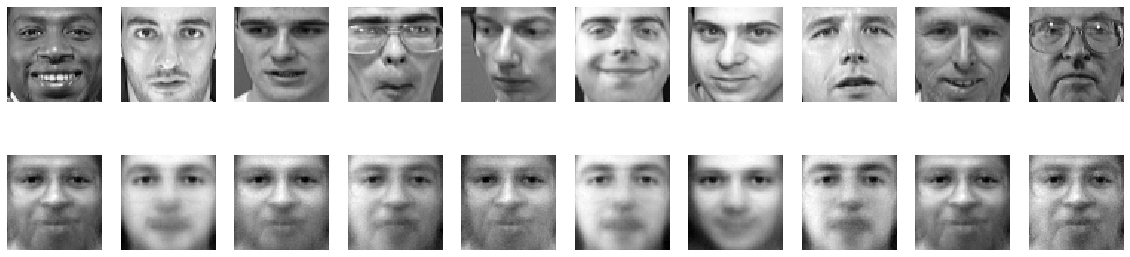

In [15]:
 ### it was for AE with ss = 128, epochs = 500, bottleneck = 50, MSE = 0.011 val
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

n_pics = 64

for i in range(10):
    im = train_dset[i][0]
    rec = net(im.reshape(1,n_pics**2).to(device))[0]
    ax[0, i].imshow(im[0].reshape(n_pics,n_pics), cmap = "gray");
    ax[1, i].imshow(rec.detach().cpu().reshape(n_pics,n_pics), cmap = "gray");
    ax[0, i].axis('off')
    ax[1, i].axis('off')

In [16]:
from matplotlib import offsetbox
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_embedding(X, y, images_small=None, title=None):
    """
    Nice plot on first two components of embedding with Offsets.
    
    """
    # take only first two columns
    X = X[:, :2]
    # scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(13,8))
    ax = plt.subplot(111)
    
    for i in range(X.shape[0] - 1):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.RdGy(y[i]),
                 fontdict={'weight': 'bold', 'size': 12})
        if images_small is not None:
            imagebox = OffsetImage(images_small[i], zoom=.4, cmap = 'gray')
            ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                xycoords='data')                                  
            ax.add_artist(ab)
    
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-1:
                # don't show points that are too close
                continue
    if title is not None:
        plt.title(title)

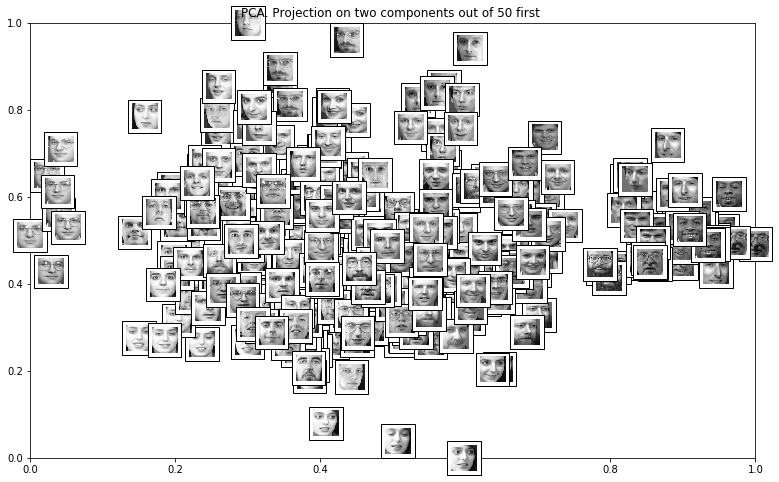

In [17]:
from sklearn.decomposition import PCA
X_projected = PCA(50).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "PCA. Projection on two components out of 50 first ")

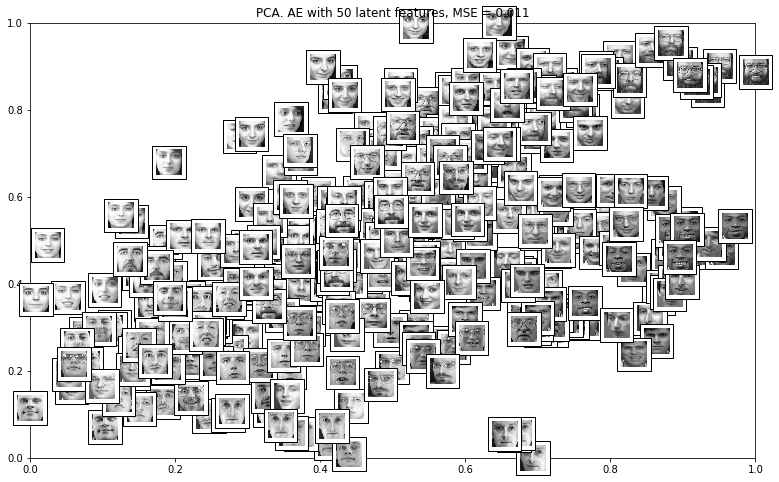

In [18]:
X_projected = net.encoder(torch.Tensor(data)).detach().numpy()
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "PCA. AE with 50 latent features, MSE = 0.011")

Questions:
* What we can derive from this embedding visually?

* How to compare the effectiveness of these embeddings?